<a href="https://colab.research.google.com/github/nahumsa/Tensorflow-Quantum/blob/master/Quantum%20Control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantum Control Optimization

This notebook is based on the TFQ whitepaper, especifically on this [notebook](https://github.com/tensorflow/quantum/blob/research/control/control.ipynb).

## 0) Importing dependencies

In [0]:
!pip install --upgrade tensorflow==2.1.0

In [0]:
!pip install tensorflow-quantum

In [0]:
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
import sympy
import cmath
import numpy as np
import scipy as sp

%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

## 1) Time constant Hamiltonian control

For this first problem we want to teach a neural network to control a quantum state which there has no time dependence. So for this specific problem we would like to use a supervised learning method, therefore we would have to collect a tuple of data (X,Y). This problem is that we want to decompose an arbitrary unitary into single-qubit gate decomposition.

The X data must be the control needed to make Y.

Up to a global phase, any one-qubit unitary can be specified in terms of 3 angles $\phi$, $\theta_1$ and $\theta_2$, such as:

\begin{equation}
  U = exp \bigg(-i \phi \big(cos\theta_1 \ X + sin\theta_1 \ \big( cos\theta_2  \ Y + sin \theta_2 \ Z \big) \big) \bigg)
\end{equation}

This can be mapped to rotations along only two non-parallel axis such as: $U = R_z(\beta) R_y(\gamma) R_z(\delta)$ , where $R_z(\delta) = exp( - \frac{\delta}{2} i Z)$ and $R_y(\delta) = exp( - \frac{\delta}{2} i Y)$.

Thus we need to map $(\phi, \theta_1, \theta_2) \rightarrow (\beta, \gamma, \delta)$, this can be done easily equating both equations and we have a helper function `map_unitary_params` that does exactly this map.

In [0]:
def get_unitary_from_params(phi, theta_1, theta_2):
  return sp.linalg.expm(-1j*phi*(
      np.cos(theta_1)*cirq.Z._unitary_()
      + np.sin(theta_1)*(
          np.cos(theta_2)*cirq.X._unitary_()
          + np.sin(theta_2)*cirq.Y._unitary_()
      )
  ))

In [0]:
def map_unitary_params(phi, theta_1, theta_2):
  """Convert unitary angles into two-axis control angles."""
  #### Below works ONLY when all input angles are less than pi

  gamma = -2*np.arccos(-np.sqrt(3 + np.cos(2 * theta_1)  + 2 * np.sin(theta_1) ** 2 * np.cos(phi* 2) )/2.0)

  delta = 2*np.real(-  1j * np.log(-(-1.0) ** (1/4) *np.sqrt(- np.exp(1j * phi) * (-1 + np.exp(2 * 1j * phi))   * 
                                                              np.sqrt(3 + np.cos(2 * theta_1)  + 2 * np.sin(theta_1) ** 2 * np.cos(phi* 2) )) /
                                      2 / np.sqrt(-np.exp(1j * ( 2 *phi+ theta_2)) * np.sin(phi) ** 2 
                                                  * (np.cos(theta_1) + 1j / np.tan(phi))) ))

  beta = 2*np.real(-  1j * np.log(- np.exp(1j * ( phi+ theta_2)) * 
                                      np.sqrt(-1j * np.exp(1j * phi)*(-1 + np.exp(2 * 1j * phi))
                                      *np.sqrt(3 + np.cos(2 * theta_1)  + 2 * np.sin(theta_1) ** 2 * np.cos(phi* 2) ))
                                      * np.sin(phi)/(-1 + np.exp(2 * 1j * phi)) /
                                      np.sqrt(- np.exp(1j * (2 * phi+ theta_2)) * np.sin(phi) *( np.sin(phi) * np.cos(theta_1) + 1j * np.cos(phi) )) ))

  return beta, gamma, delta

### 1.1) Training data
Now we can construct our traning data, which is $(\beta, \gamma, \delta)$ distributed uniformly and we split into a training and validation sets.

In [0]:
def get_angles_training_data(batch_size):
    data = []
    labels = []
    for _ in range(batch_size):
      random_unitary_params = np.random.uniform(0,  np.pi, (3)).tolist()
      beta, gamma, delta = map_unitary_params(*random_unitary_params)
      data.append(random_unitary_params)
      labels.append([beta, gamma, delta])
    return data, labels

In [0]:
train_size = 10000
validation_size = 10000
all_commands, all_expectations = get_angles_training_data(train_size + validation_size)

commands_train = all_commands[:train_size]
expectations_train = all_expectations[:train_size]
commands_val = all_commands[-validation_size:]
expectations_val = all_expectations[-validation_size:]

Let's see if the data is consistent with what we assumed. So we will use the inner product $\left< U, V \right> = \mathrm{Tr} ( U^{\dagger}V )$ and see how far both unitaries are from each other.

In [0]:
def inner_product(V,U):
  return np.trace(np.matmul(V.conj().T, U)) ** 2 / 2**(len(V))


q = cirq.GridQubit(0, 0)
for data_angles, label_angles in zip(commands_train, all_expectations):
  test_phi, test_theta_1, test_theta_2 = data_angles
  beta = label_angles[0]
  gamma = label_angles[1]
  delta = label_angles[2]
  U = get_unitary_from_params(test_phi, test_theta_1, test_theta_2)
  V = np.matmul(cirq.rz(beta)._unitary_(),
      np.matmul(cirq.ry(gamma)._unitary_(), cirq.rz(delta)._unitary_()))

  circuit = cirq.Circuit(cirq.rz(delta)(q), cirq.ry(gamma)(q), cirq.rz(beta)(q))
 
  check1= inner_product(V, circuit.unitary())  

  check = inner_product(V, U)
  
  if (abs(abs(check) - 1) > 1e-5) and (abs(abs(check1) - 1) > 1e-5):
    print(f"Inner product value: {check}")    
    print(f"Input angles quadrant check: {[int(test_phi>np.pi), int(test_theta_1>np.pi), int(test_theta_2>np.pi)]}")    

Let' prepare the training data using the expectation values for each circuit. For this we will use the `Expectation` layer on TFQ, this layer, as the name suggests, calculate the expectation value of observables for a given circuit and parameter values.

For our case we will do the state tomography ,that is getting the expectation value of X, Y and Z.

In [0]:
def get_expectation_training_data(batch_size):
    q = cirq.GridQubit(0, 0)
    beta_s, gamma_s, delta_s = sympy.symbols("beta gamma delta")
    circuit = cirq.Circuit(cirq.rz(delta_s)(q), cirq.ry(gamma_s)(q), cirq.rz(beta_s)(q))
    ops = [cirq.X(q), cirq.Y(q), cirq.Z(q)] #Observables

    params = []
    outputs = []
    for _ in range(batch_size):
      random_unitary_params = np.random.uniform(0,  np.pi, (3)).tolist()
      beta, gamma, delta = map_unitary_params(*random_unitary_params)
      expectations = tfq.layers.Expectation()(
          circuit, 
          symbol_names=[beta_s, gamma_s, delta_s],
          symbol_values=[[beta, gamma, delta]],
          operators=ops 
      ).numpy().tolist()[0]
      params.append(random_unitary_params)
      outputs.append(expectations)
    return params, outputs

Let's convert the data into commands of the circuit using the `get_expectation_training_data`.

Since we are using a supervised learning method, we need to gather the (X, Y) tuples for training. 

The input of the neural is the circuit and the commands for that circuit, the output is the expectation values of X, Y and Z.

In [0]:
train_size = 10000
validation_size = 10000
all_commands, all_expectations = get_expectation_training_data(train_size + validation_size)

commands_train = all_commands[:train_size]
expectations_train = all_expectations[:train_size]
commands_val = all_commands[-validation_size:]
expectations_val = all_expectations[-validation_size:]

X = [tfq.convert_to_tensor([cirq.Circuit()]*train_size), tf.convert_to_tensor(commands_train)]
Y = tf.convert_to_tensor(expectations_train)
val_X = [tfq.convert_to_tensor([cirq.Circuit()]*validation_size), tf.convert_to_tensor(commands_val)]
val_Y = tf.convert_to_tensor(expectations_val)

### 1.2) Building the model

Let's now build a hybrid classical-quantum neural network to control $\beta, \gamma, \delta$

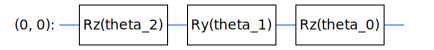

In [20]:
#parameters that will be fed into the QNN
control_params = sympy.symbols([f'theta_{n}' for n in range(3)])

#Creating parametrized circuit
qubit = cirq.GridQubit(0,0)
two_axis_control_circuit = cirq.Circuit(
                    cirq.rz(control_params[2])(qubit),
                    cirq.ry(control_params[1])(qubit),
                    cirq.rz(control_params[0])(qubit)
                    )

#Let's measure along X, Y and Z
pauli_x = cirq.PauliString(cirq.X(qubit))
pauli_y = cirq.PauliString(cirq.Y(qubit))
pauli_z = cirq.PauliString(cirq.Z(qubit))
measurements = [pauli_x, pauli_y, pauli_z]

#display circuit
SVGCircuit(two_axis_control_circuit)

For our model we will need to use the `ControlledPQC` layer, which needs the output of another layer to provide the parameters for the circuit.

In [0]:
circuits_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string, name='circuits_input')
commands_input = tf.keras.Input((3,), name='commands_input')
dense_layer_1 = tf.keras.layers.Dense(128, activation='relu', name='dense_layer_1')(commands_input)
dense_layer_2 = tf.keras.layers.Dense(128, name='dense_layer_2')(dense_layer_1)
dense_layer_3 = tf.keras.layers.Dense(64, activation='relu', name='dense_layer_3')(dense_layer_2) 
angles_layer = tf.keras.layers.Dense(3,  activation='linear', name='angles_layer')(dense_layer_3)

measured_expectations = tfq.layers.ControlledPQC(
    two_axis_control_circuit, measurements)([circuits_input, angles_layer])

two_axis_control_model = tf.keras.Model(inputs=[circuits_input, commands_input], outputs=measured_expectations)

### 1.3) Training the model

Let's train with the Adam optimizer and a decay learning rate.

In [0]:
epochs = 100
batch_size = 1024
lr=0.010 

optimizer = tf.keras.optimizers.Adam(learning_rate=lr, decay= lr / epochs)

two_axis_control_model.compile(optimizer=optimizer, loss= 'mse')

history = two_axis_control_model.fit(x=X,
                                     y=Y, 
                                     batch_size=batch_size, 
                                     epochs=epochs,
                                     validation_data=(val_X, val_Y),                                     
                                      )

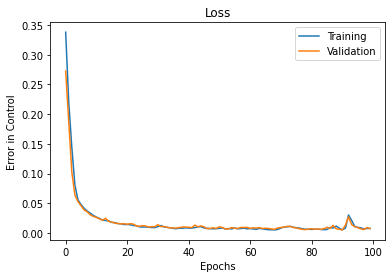

In [49]:
history = history.history
loss = history['loss']
val_loss = history['val_loss']
plt.plot(loss, label='Training')
plt.plot(val_loss, label='Validation')
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Error in Control")
plt.legend()
plt.show()